In [0]:
!git clone https://bitbucket.org/jadslim/german-traffic-signs

fatal: destination path 'german-traffic-signs' already exists and is not an empty directory.


In [0]:
!ls german-traffic-signs

signnames.csv  test.p  train.p	valid.p


In [0]:
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.utils.np_utils import to_categorical
from keras.layers import Dropout, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
import pickle
import pandas as pd
import random

np.random.seed(0)

In [0]:
with open('german-traffic-signs/train.p', 'rb') as f:
  train_data = pickle.load(f)
  
with open('german-traffic-signs/valid.p', 'rb') as f:
  val_data = pickle.load(f)
  
with open('german-traffic-signs/test.p', 'rb') as f:
  test_data = pickle.load(f)
  
X_train, y_train = train_data['features'], train_data['labels']
X_val, y_val = val_data['features'], val_data['labels']
X_test, y_test = test_data['features'], test_data['labels']


In [0]:
assert(X_train.shape[0] == y_train.shape[0]), 'The number of images is not equal to the number of labels'
assert(X_val.shape[0] == y_val.shape[0]), 'The number of images is not equal to the number of labels'
assert(X_test.shape[0] == y_test.shape[0]), 'The number of images is not equal to the number of labels'
assert(X_train.shape[1:] == (32, 32, 3)), 'The dimensions of the images are not 32 x 32 x 3'
assert(X_val.shape[1:] == (32, 32, 3)), 'The dimensions of the images are not 32 x 32 x 3'
assert(X_test.shape[1:] == (32, 32, 3)), 'The dimensions of the images are not 32 x 32 x 3'

In [0]:
data = pd.read_csv('german-traffic-signs/signnames.csv')

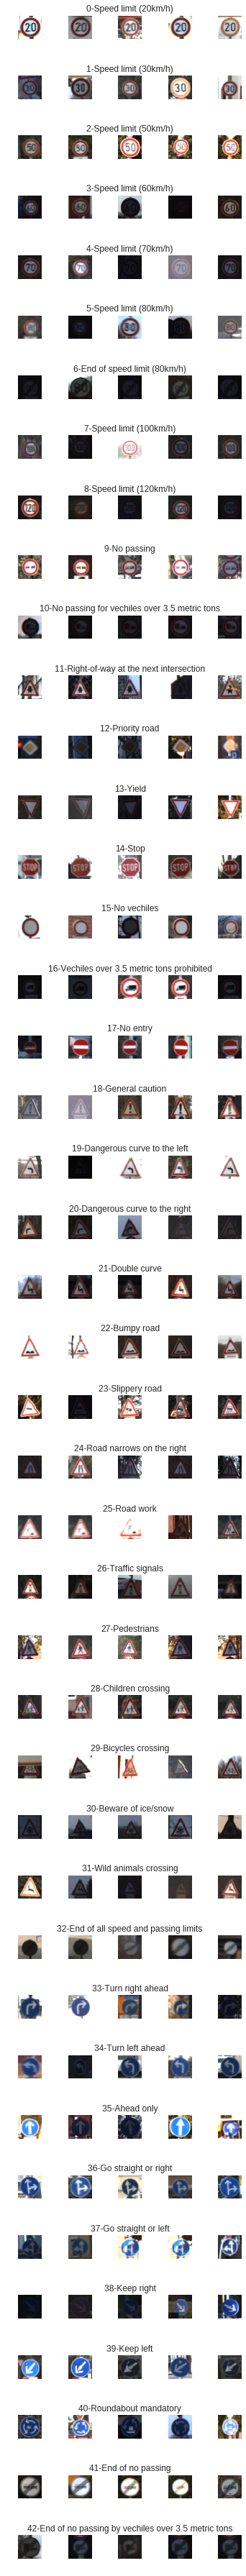

In [0]:
num_of_samples = []
 
cols = 5
num_classes = 43
 
fig, axs = plt.subplots(nrows=num_classes, ncols = cols, figsize=(5, 50))
fig.tight_layout()
for i in range(cols):
    for j, row in data.iterrows():
        x_selected = X_train[y_train == j]
        axs[j][i].imshow(x_selected[random.randint(0, len(x_selected - 1)), :, :], cmap=plt.get_cmap("gray"))
        axs[j][i].axis("off")
        if i == 2:
            axs[j][i].set_title(str(j) + '-' + row['SignName'])
            num_of_samples.append(len(x_selected))

[180, 1980, 2010, 1260, 1770, 1650, 360, 1290, 1260, 1320, 1800, 1170, 1890, 1920, 690, 540, 360, 990, 1080, 180, 300, 270, 330, 450, 240, 1350, 540, 210, 480, 240, 390, 690, 210, 599, 360, 1080, 330, 180, 1860, 270, 300, 210, 210]


Text(0, 0.5, 'Number of images')

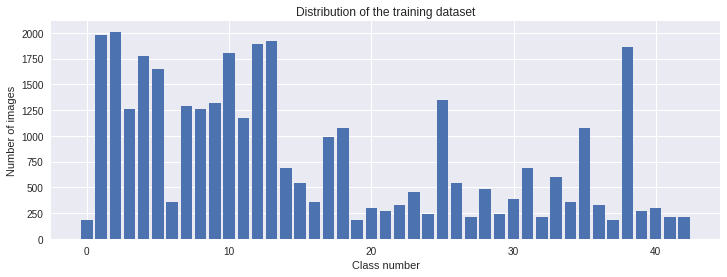

In [0]:
print(num_of_samples)
plt.figure(figsize=(12, 4))
plt.bar(range(0, num_classes), num_of_samples)
plt.title("Distribution of the training dataset")
plt.xlabel("Class number")
plt.ylabel("Number of images")

(32, 32, 3)
36


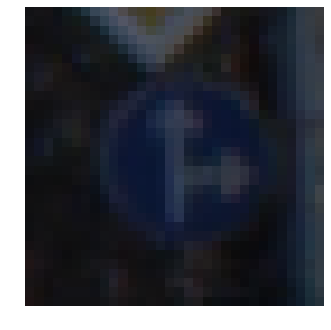

In [0]:
import cv2

plt.imshow(X_train[1000])
plt.axis('off')
print(X_train[1000].shape)
print(y_train[1000])

(-0.5, 31.5, 31.5, -0.5)

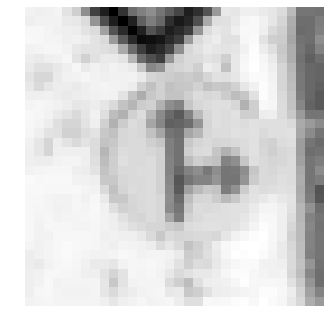

In [0]:
def grayscale(img):
  return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

img = grayscale(X_train[1000])
plt.imshow(img)
plt.axis('off')

(-0.5, 31.5, 31.5, -0.5)

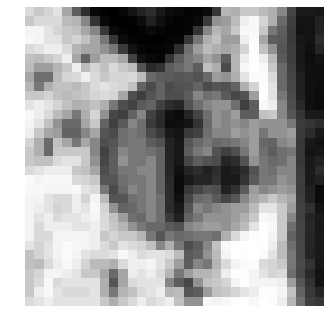

In [0]:
def equalize(img):
  # normalize the bright of an image
  return cv2.equalizeHist(img)

img = equalize(img)
plt.imshow(img)
plt.axis('off')

In [0]:
def preprocessing(img):
  img = grayscale(img)
  img = equalize(img)
  img = img / 255
  return img

X_train = np.array(list(map(preprocessing, X_train)))
X_val = np.array(list(map(preprocessing, X_val)))
X_test = np.array(list(map(preprocessing, X_test)))

(-0.5, 31.5, 31.5, -0.5)

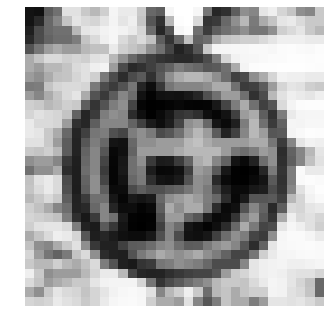

In [0]:
plt.imshow(X_train[random.randint(0, len(X_train) -1)])
plt.axis('off')

In [0]:
X_train = X_train.reshape(34799, 32, 32, 1)
X_val = X_val.reshape(4410, 32, 32, 1)
X_test = X_test.reshape(12630, 32, 32, 1)

In [0]:
# we have to do this because we need variation in our data, such as rotate, zoom, etc.
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(width_shift_range=0.1, # if value >= 1 will move the image by pixel, else by percentage. the image will go a lit bit for right or left 
                   height_shift_range=0.1, # same here ^^, but up or down
                   zoom_range=0.2, # 
                   shear_range=0.1, # 
                   rotation_range=10) # rotate by degrees

datagen.fit(X_train)

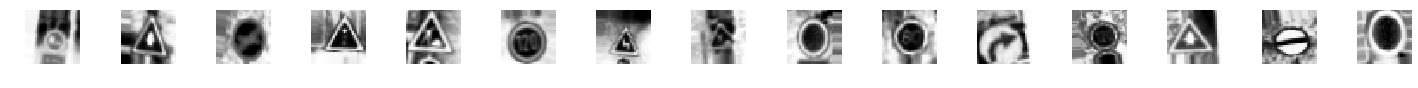

In [0]:
batches = datagen.flow(X_train, y_train, batch_size=20)
X_batch, y_batch = next(batches)

fig, axs = plt.subplots(1, 15, figsize=(20, 5))
fig.tight_layout()

for i in range(15):
  axs[i].imshow(X_batch[i].reshape(32, 32))
  axs[i].axis('off')

In [0]:
y_train = to_categorical(y_train, 43)
y_val = to_categorical(y_val, 43)
y_test = to_categorical(y_test, 43)

In [0]:
def leNet_model():
  model = Sequential()
  model.add(Conv2D(60, (5, 5), input_shape=(32, 32, 1), activation='relu')) # filters, size of filters (kernels)
  model.add(Conv2D(60, (5, 5), activation='relu')) # filters, size of filters (kernels)
  model.add(MaxPooling2D(pool_size=(2, 2)))
  
  model.add(Conv2D(30, (3, 3), activation='relu'))
  model.add(Conv2D(30, (3, 3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
#   model.add(Dropout(0.5)) # 0.5 = recommended

  model.add(Flatten())
  model.add(Dense(500, activation='relu'))
  model.add(Dropout(0.5)) # 0.5 = recommended
  model.add(Dense(num_classes, activation='softmax'))
  model.compile(Adam(lr= 0.001), loss='categorical_crossentropy', metrics=['accuracy'])
  return model


model = leNet_model()
print(model.summary())
   

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_48 (Conv2D)           (None, 28, 28, 60)        1560      
_________________________________________________________________
conv2d_49 (Conv2D)           (None, 24, 24, 60)        90060     
_________________________________________________________________
max_pooling2d_32 (MaxPooling (None, 12, 12, 60)        0         
_________________________________________________________________
conv2d_50 (Conv2D)           (None, 10, 10, 30)        16230     
_________________________________________________________________
conv2d_51 (Conv2D)           (None, 8, 8, 30)          8130      
_________________________________________________________________
max_pooling2d_33 (MaxPooling (None, 4, 4, 30)          0         
_________________________________________________________________
flatten_16 (Flatten)         (None, 480)               0         
__________

In [0]:
history = model.fit_generator(datagen.flow(X_train, y_train, batch_size=70), steps_per_epoch=2000, epochs=10, validation_data=(X_val, y_val), shuffle=1)
# (X_train, y_train, epochs=10, validation_data=(X_val, y_val), batch_size=400, verbose=1, shuffle=1)

Epoch 1/10
2000/2000 [==============================] - 68s 34ms/step - loss: 0.7098 - acc: 0.7923 - val_loss: 0.0519 - val_acc: 0.9846
Epoch 2/10
2000/2000 [==============================] - 66s 33ms/step - loss: 0.1517 - acc: 0.9526 - val_loss: 0.0463 - val_acc: 0.9864
Epoch 3/10
2000/2000 [==============================] - 68s 34ms/step - loss: 0.1004 - acc: 0.9684 - val_loss: 0.0290 - val_acc: 0.9923
Epoch 4/10
2000/2000 [==============================] - 67s 33ms/step - loss: 0.0812 - acc: 0.9745 - val_loss: 0.0386 - val_acc: 0.9859
Epoch 5/10
2000/2000 [==============================] - 66s 33ms/step - loss: 0.0658 - acc: 0.9798 - val_loss: 0.0282 - val_acc: 0.9921
Epoch 6/10
2000/2000 [==============================] - 66s 33ms/step - loss: 0.0590 - acc: 0.9815 - val_loss: 0.0348 - val_acc: 0.9893
Epoch 7/10
2000/2000 [==============================] - 66s 33ms/step - loss: 0.0535 - acc: 0.9837 - val_loss: 0.0224 - val_acc: 0.9948
Epoch 8/10
2000/2000 [==========================

Text(0.5, 0, 'epoch')

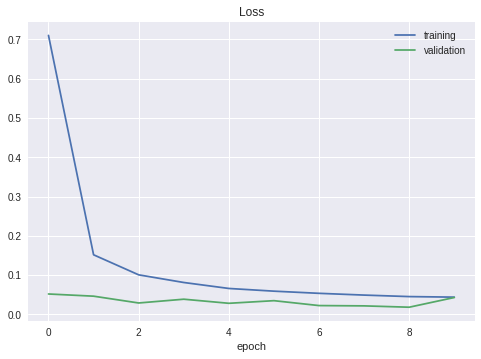

In [0]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Loss')
plt.xlabel('epoch')

Text(0.5, 0, 'epoch')

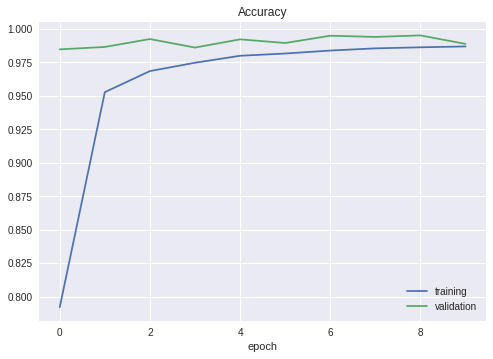

In [0]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.legend(['training', 'validation'])
plt.title('Accuracy')
plt.xlabel('epoch')

In [0]:
score = model.evaluate(X_test, y_test, verbose =0)
print('test score:', score[0])
print('test accuracy:', score[1])

test score: 0.13398374408582858
test accuracy: 0.9745843230592572


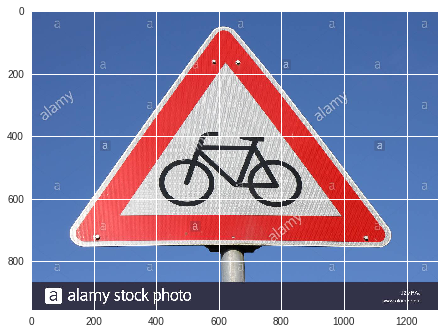

In [0]:
#fetch image
 
import requests
from PIL import Image
url = 'https://c8.alamy.com/comp/G667W0/road-sign-speed-limit-30-kmh-zone-passau-bavaria-germany-G667W0.jpg'
url = 'https://c8.alamy.com/comp/A0RX23/cars-and-automobiles-must-turn-left-ahead-sign-A0RX23.jpg'
url = 'https://previews.123rf.com/images/bwylezich/bwylezich1608/bwylezich160800375/64914157-german-road-sign-slippery-road.jpg'
url = 'https://previews.123rf.com/images/pejo/pejo0907/pejo090700003/5155701-german-traffic-sign-no-205-give-way.jpg'
url = 'https://c8.alamy.com/comp/J2MRAJ/german-road-sign-bicycles-crossing-J2MRAJ.jpg'
r = requests.get(url, stream=True)
img = Image.open(r.raw)
plt.imshow(img, cmap=plt.get_cmap('gray'))

(32, 32)
predicted sign: [29]


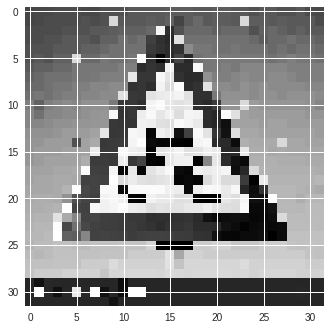

In [0]:
 
#Preprocess image
 
img = np.asarray(img)
img = cv2.resize(img, (32, 32))
img = preprocessing(img)
plt.imshow(img, cmap = plt.get_cmap('gray'))
print(img.shape)
 
#Reshape reshape
 
img = img.reshape(1, 32, 32, 1)
 
#Test image
print("predicted sign: "+ str(model.predict_classes(img)))